In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [1271]:
def create_group_nest(size, n_contineous_features, num_of_branch, initial_intercept = 1):

    from collections import Counter
    
    def make_random_split(size):
        '''
        Splits number in two parts so that a+b = size
        '''
        random_split = np.sqrt(np.abs(np.round(np.random.randn(2), 3))) 
        total = random_split.sum()
        probability = random_split/total
        splits = np.random.multinomial(size, probability)
        return splits
    
    cat_length = size # assign initial size to a category
    
    # generating fixed part simply y = mx + c
    X = np.random.uniform(-1, 1, size * n_contineous_features).reshape((size, n_contineous_features))
    betas = np.random.randint(10, size = n_contineous_features)
    Xbeta = initial_intercept + X @ betas
    fX = Xbeta
    data = pd.DataFrame(X)
    x_cols = ['f' + str(i) for i in range(n_contineous_features)]
    data.columns = x_cols
    e = np.random.normal(0, 1, size)
    y = fX + e
    
    # creating group - splits and random intercept part
    for i in range(0, num_of_branch):
        
        if cat_length == 1:
            print("Warning: Nesting limit reached!!!")
            break
    
        splits = make_random_split(size)        
        array_counts = []
        if i < 1:
            array_counts = [size]
        else:
            array_counts = split_cnt
        
        split_cnt = []
        random_intercepts = []
        for cnt in array_counts:
            split_ = make_random_split(cnt)
            split_cnt.extend(split_)
            random_intercepts.extend(np.random.randint(20, size = len(split_)))
            
        X = np.repeat(range(len(split_cnt)), split_cnt)

        u0 = np.repeat(random_intercepts, split_cnt)
        y = y + u0
    
#         print("array_counts", array_counts)
#         print("split_cnt", split_cnt)
#         print("random_intercepts_combined", random_intercepts)
#         print(X)
#         print(u0)
        
        cat_length = Counter(X)[X[0]]
        data[f'g{i}'] = X
    
    data['y'] = y
    return data

df = create_group_nest(1000,2,3)
df

,f0,f1,g0,g1,g2,y
0,0.941832,0.041265,0,0,0,32.889501
1,-0.968356,0.238881,0,0,0,20.749790
2,-0.862965,-0.073222,0,0,0,18.262130
3,0.679994,0.993448,0,0,0,39.116263
4,-0.663128,-0.261113,0,0,0,19.346346
...,...,...,...,...,...,...
995,-0.945371,-0.919068,1,3,7,19.868096
996,0.348023,-0.779438,1,3,7,28.859385
997,-0.635382,-0.403015,1,3,7,25.313078
998,-0.872069,-0.825070,1,3,7,18.140213


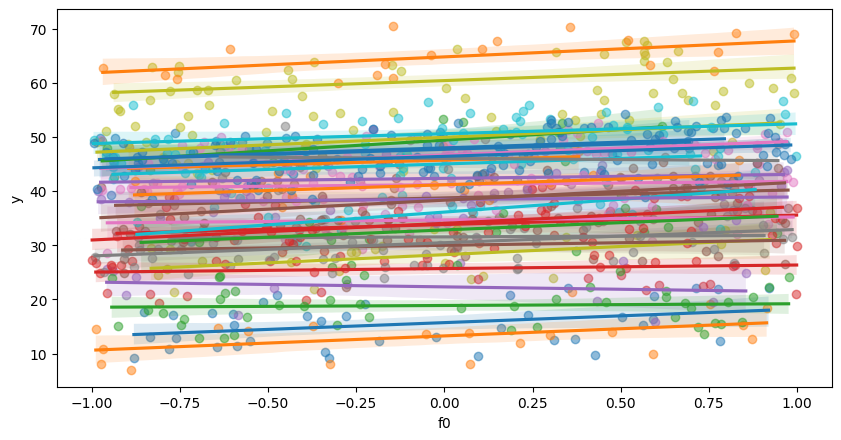

In [1176]:
fig_width = 10  # Width of the figure in inches
fig_height = 5  # Height of the figure in inches
fig_dpi = 100  # Dots per inch (resolution)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_dpi)

col = "g4"

for i in np.unique(df[col]):
    sns.regplot(df[df[col] == i]['f0'], df[df[col] == i]['y'],scatter_kws={"alpha": 0.5})

array_counts [1000]
split_cnt [698, 302]
random_intercepts_combined [15, 9]
array_counts [698, 302]
split_cnt [254, 444, 123, 179]
random_intercepts_combined [14, 2, 4, 0]
array_counts [254, 444, 123, 179]
split_cnt [152, 102, 144, 300, 54, 69, 74, 105]
random_intercepts_combined [4, 1, 2, 18, 0, 10, 17, 1]
Intercept: 24.622541109076337

Coefficients: [  8.01335044   8.88938619   9.22159686   6.3636081   -4.72583002
  11.35005837 -10.31669555  -0.83142949   2.35156764 -13.41287592]

MSE: 1.1053722486608448


Shapiro-Wilk test:
statistic: 0.9914147853851318
p-value: 0.05225304886698723
Jarque-Bera test:
statistic: 1.7866054816510557
p-value: 0.409301700505155


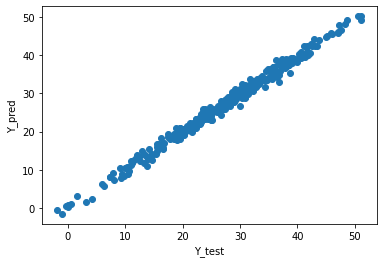

In [1270]:
from sklearn.model_selection import train_test_split

np.random.seed(100)
df = create_group_nest(1000,2,3)
# df = create_nested_data_random_intercept(1000, 3, [2,4,8,16,32], 1, [1,1,1,1,1])

g_cols = [col for col in df.columns if col.startswith('g')]
df['g_cart'] = df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
df["g_cart"] = pd.factorize(df['g_cart'])[0]
df.drop(g_cols, axis=1, inplace=True)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
column_to_encode = ['g_cart']
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df[column_to_encode])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(column_to_encode))
final_df = pd.concat([df, encoded_df], axis=1)
final_df.drop(['g_cart'], axis=1, inplace=True)
df = final_df.copy()

X,y = df.drop('y', axis=1), df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
results = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

intercept = model.intercept_
coefficients = model.coef_

print(f"Intercept: {intercept}")
print(f"\nCoefficients: {coefficients}")
print(f"\nMSE: {mse(y_test, y_pred)}")

import scipy.stats as stats

stat, pvalue = stats.shapiro(y_pred-y_test)
print("\n\nShapiro-Wilk test:")
print("statistic:", stat)
print("p-value:", pvalue)

# Jarque-Bera test
stat, pvalue = stats.jarque_bera(y_pred-y_test)
print("Jarque-Bera test:")
print("statistic:", stat)
print("p-value:", pvalue)

plt.scatter(y_test, y_pred)
plt.ylabel('Y_pred')
plt.xlabel('Y_test')
plt.show()

array_counts [1000]
split_cnt [698, 302]
random_intercepts_combined [15, 9]
array_counts [698, 302]
split_cnt [254, 444, 123, 179]
random_intercepts_combined [14, 2, 4, 0]
array_counts [254, 444, 123, 179]
split_cnt [152, 102, 144, 300, 54, 69, 74, 105]
random_intercepts_combined [4, 1, 2, 18, 0, 10, 17, 1]
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    y        
No. Observations:    670        Method:                REML     
No. Groups:          8          Scale:                 0.9416   
Min. group size:     39         Log-Likelihood:        -939.2557
Max. group size:     198        Converged:             Yes      
Mean group size:     83.8                                       
----------------------------------------------------------------
              Coef.    Std.Err.     z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------
Intercept      33.844      0.975  34.711 0.000   31.933

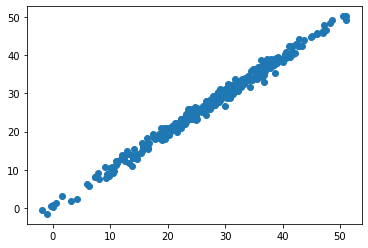

In [1266]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse

np.random.seed(100)
df = create_group_nest(1000,2,3)
# df = create_nested_data_random_intercept(1000, 3, [2,4,8,16,32], 1, [1,1,1,1,1])

g_cols = [col for col in df.columns if col.startswith('g')]
df['g_cart'] = df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
df["g_cart"] = pd.factorize(df['g_cart'])[0]
# df.drop(g_cols, axis=1, inplace=True)

X, y = df.drop('y', axis=1), df['y']
x_cols = [col for col in X.columns if col if not col.startswith('g')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

data_train = pd.concat([X_train, y_train], axis=1)

md = sm.MixedLM.from_formula("y ~ f0 + f1 + (0 | g0*g1*g2)", data_train, groups = data_train['g_cart'])
mdf = md.fit()
print(mdf.summary())
print("MSE-train: ", mse(data_train.y, mdf.fittedvalues))
mlm_pred = mdf.predict(X_test)
print("MSE-test: ", mse(y_test, mlm_pred),"\n\n")
import scipy.stats as stats

stat, pvalue = stats.shapiro(mlm_pred-y_test)
print("Shapiro-Wilk test:")
print("statistic:", stat)
print("p-value:", pvalue)

# Jarque-Bera test
stat, pvalue = stats.jarque_bera(mlm_pred-y_test)
print("Jarque-Bera test:")
print("statistic:", stat)
print("p-value:", pvalue)

plt.scatter(y_test, mlm_pred)
plt.show()

array_counts [1000]
split_cnt [698, 302]
random_intercepts_combined [15, 9]
array_counts [698, 302]
split_cnt [254, 444, 123, 179]
random_intercepts_combined [14, 2, 4, 0]
array_counts [254, 444, 123, 179]
split_cnt [152, 102, 144, 300, 54, 69, 74, 105]
random_intercepts_combined [4, 1, 2, 18, 0, 10, 17, 1]
1.1131748848156893


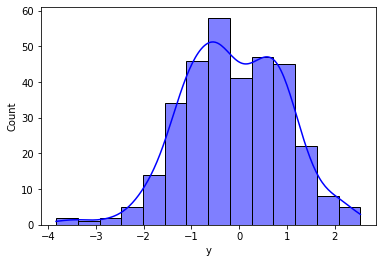

Shapiro-Wilk test:
statistic: 0.9913277626037598
p-value: 0.04976097121834755
Jarque-Bera test:
statistic: 1.7288556693448724
p-value: 0.42129253266048694


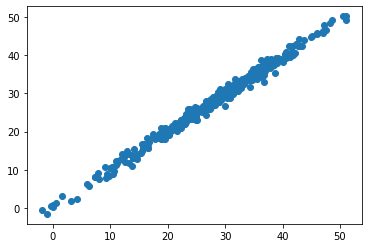

In [1263]:
np.random.seed(100)
df_original = create_group_nest(1000,2,3)
# df_original = create_nested_data_random_intercept(10000, 3, [2,4,8,16,32], 1, [0.01,0.1,1,10,100])
df = df_original.copy()

mse_lmm, mse_lr, time_lmm, y_test, y_pred = run_all([f'g{i}' for i in range(3)])
print(mse_lmm)
sns.histplot(y_pred-y_test, kde=True, color='b')
plt.show()
plt.scatter(y_test, y_pred)

import scipy.stats as stats

stat, pvalue = stats.shapiro(y_pred-y_test)
print("Shapiro-Wilk test:")
print("statistic:", stat)
print("p-value:", pvalue)

# Jarque-Bera test
stat, pvalue = stats.jarque_bera(y_pred-y_test)
print("Jarque-Bera test:")
print("statistic:", stat)
print("p-value:", pvalue)

In [1233]:
df_original

,f0,f1,f2,g0,g1,g2,g3,g4,y
0,-0.314547,-0.441088,0.601249,0,0,0,0,0,2.273232
1,-0.805161,0.693791,-0.302454,0,0,0,0,0,2.353795
2,-0.320002,-0.175600,-0.813060,0,0,0,0,0,2.768956
3,0.522948,0.011195,0.046660,0,0,0,0,0,2.228422
4,0.343753,0.492415,-0.509923,0,0,0,0,0,1.373864
...,...,...,...,...,...,...,...,...,...
995,0.145388,0.024599,0.445433,1,3,7,15,31,-15.483598
996,-0.811180,-0.145747,-0.454296,1,3,7,15,31,-18.210240
997,0.961470,-0.517607,-0.875533,1,3,7,15,31,-17.370688
998,0.069574,-0.219159,0.756591,1,3,7,15,31,-15.462011


# LMMM Synthetic

In [584]:
def create_nested_data_random_intercept(N, n_contineous_features, qs, sig2e, sig2bs, intial_intercept=1, n_per_cat=3):
    
    X = np.random.uniform(-1, 1, N * n_contineous_features).reshape((N, n_contineous_features))
    betas = np.ones(n_contineous_features)
    Xbeta = intial_intercept + X @ betas
    fX = Xbeta
    df = pd.DataFrame(X)
    x_cols = ['f' + str(i) for i in range(n_contineous_features)]
    df.columns = x_cols
    e = np.round(np.random.normal(0, np.sqrt(sig2e), N), 2)
    y = fX + e
    for k, q in enumerate(qs):
        fs = np.random.poisson(n_per_cat, q) + 1
        fs_sum = fs.sum()
        ps = fs/fs_sum
        ns = np.random.multinomial(N, ps)
        Z_idx = np.repeat(range(q), ns)
        b = np.random.normal(0, np.sqrt(sig2bs[k]), q)
        gZb = np.repeat(b, ns)
        y = y + gZb
        df['g' + str(k)] = Z_idx
    df['y'] = y
    
    return df

In [1186]:
N = 1000
n_contineous_features = 3
qs = [2,4,8,16,32]
sig2e = 1
sig2bs = [1,1,1,1,1]
df = create_nested_data_random_intercept(1000, 3, [2,4,8,16,32], 1, [1,1,1,1,1])
df

,f0,f1,f2,g0,g1,g2,g3,g4,y
0,0.699780,-0.198740,0.142389,0,0,0,0,0,1.381508
1,0.445341,0.038182,-0.232867,0,0,0,0,0,3.268735
2,0.563090,-0.896889,-0.144840,0,0,0,0,0,0.459440
3,-0.047203,0.759350,-0.003913,0,0,0,0,0,0.816313
4,0.084516,0.289870,0.561054,0,0,0,0,0,2.363519
...,...,...,...,...,...,...,...,...,...
995,0.040619,0.669292,0.826010,1,3,7,15,31,3.689089
996,0.828585,0.162637,0.668498,1,3,7,15,31,2.712888
997,-0.447408,-0.953629,-0.990192,1,3,7,15,31,1.581938
998,0.052985,0.857765,-0.679091,1,3,7,15,31,1.724826


In [1216]:
from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_lmm, reg_nn_embed, reg_nn_rnn
from lmmnn.simulation import Count
from lmmnn.utils import *
import gc
import time
import tensorflow.keras.backend as K

def run_all(g_cols):

    df = df_original.copy()
    # g_cols = ['g1','g2','g3', 'g4', 'g5', 'g6','g7']
    col_to_select = list(col for col in df_original.columns if col.startswith('f') or col.startswith('y')) + g_cols
    df = df_original[col_to_select].copy()
    df['g_cart'] = df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
    df["g_cart"] = pd.factorize(df['g_cart'])[0]
#     df.drop(g_cols, axis=1, inplace=True)

    if len(g_cols) == 1:
        df.drop(g_cols, axis=1, inplace=True)

#     print(df.head())

    df.rename(columns={'g_cart': 'z0'}, inplace=True)
    df.rename(columns={f'{col}': f'z{i+1}' for i, col in enumerate(g_cols)}, inplace=True)
#     print(df.head())

    z_cols = sorted([col for col in df.columns if col.startswith('z')], key=lambda x: int(x[1:]))

    # mode = 'slopes'
    mode = 'intercepts'
    n_cats = [len(df[i].unique()) for i in z_cols]
    qs = n_cats
    batch_size = 100
    epochs = 500
    patience = 10
    n_sig2bs = len(n_cats)
    n_sig2bs_spatial = 0
    est_cors = []
    n_neurons = [50,25,12,6]
    activation = 'linear'
    dropout = []
    spatial_embedded_neurons = []
    dist_matrix = None
    q_spatial = None

#     print('n_uniques: ', n_cats)

    X, y = df.drop('y', axis=1), df['y']
    x_cols = [col for col in X.columns if col if not col.startswith('z')]#['z0','z1','z2','z3']]
#     cols_to_scale = [col for col in X.columns if col not in ['z0','z1','z2','z3','t']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train[x_cols] = scaler.fit_transform(X_train[x_cols])
    X_test[x_cols]  = scaler.transform(X_test[x_cols])
    
#     print(X_train)

    reg = LinearRegression(fit_intercept=True)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    mse_lr = mse(y_test,pred)

#     print(X_train.head())

    def reg_nn(X_train, X_test, y_train, y_test, n_cats, batch=batch_size, epochs=epochs, patience=patience, reg_type='lmm', verbose=False):

        start = time.time()
        if reg_type == 'lmm':
            model_fitted, history, y_pred, sigmas, _, _, n_epochs = reg_nn_lmm(X_train, X_test, y_train, y_test, n_cats, q_spatial, x_cols, batch, epochs, patience,
                                                     n_neurons, dropout, activation,
                                                     mode=mode, n_sig2bs=n_sig2bs, n_sig2bs_spatial=n_sig2bs_spatial,
                                                     est_cors=est_cors, dist_matrix=dist_matrix,
                                                     spatial_embed_neurons=spatial_embedded_neurons, verbose=verbose, log_params=False)
        else:
            raise ValueError(reg_type + 'is an unknown reg_type')
        end = time.time()
        gc.collect()
        K.clear_session()
        mse = np.mean((y_pred - y_test)**2)
        return mse, sigmas, n_epochs, end - start, y_pred

    mse_lmm, sigmas, n_epochs_lmm, time_lmm,y_pred= reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='lmm', verbose=False)
#     print(' finished lmm, mse: %.4f' % (mse_lmm))
#     print(' finished lmm, MAE: ',(mae(y_test, y_pred)))

    return mse_lmm, mse_lr, time_lmm, y_test, y_pred 